In [1]:
import sys
import os

sys.path.append(os.path.abspath("../src"))

In [2]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO

SEED = 42

class Inference:
    def __init__(self, model, file_path):
        """
        model: object Detector or Segmenter
        file_path: path to file (image or video)
        """
        self.model = model
        self.file_path = file_path
        self.n_classes = len(self.model.class_names)
        self.image_exts = ['.jpg', '.jpeg', '.webp', '.png']
        self.video_exts = ['.mp4', '.mov', '.avi', '.mkv']

        random.seed(SEED)
        self.colors = [tuple([random.random() for _ in range(3)]) for _ in range(self.n_classes)]

        self.video_model = YOLO(model.model.ckpt_path) if hasattr(model, "model") else None

    def get_class_color(self, cls_id):
        return self.colors[cls_id % len(self.colors)]

    def visualize_prediction(self, img, results):
        _, ax = plt.subplots(figsize=(12, 8))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)

        has_masks = "masks" in results and any(m is not None for m in results["masks"]) # masks for making an universal class

        for i in range(len(results["boxes"])):
            box = results["boxes"][i]
            cls_id = results["classes"][i]
            confidence = results["confidences"][i]
            x0, y0, x1, y1 = map(int, box)

            label = self.model.class_names[cls_id]
            text = f'{label} {confidence:.2f}'
            color = self.get_class_color(cls_id)

            rect = patches.Rectangle(
                (x0, y0), x1 - x0, y1 - y0,
                linewidth=1.0, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rect)

            ax.text(
                x0, y0, text,
                verticalalignment='top',
                bbox=dict(facecolor='black', alpha=0.7, pad=1, edgecolor='none'),
                color='white',
                fontsize=8
            )

            if has_masks and results["masks"][i] is not None:
                polygon = np.array(results["masks"][i], dtype=np.int32)
                poly_patch = patches.Polygon(
                    polygon, closed=True, facecolor=color, alpha=0.45, edgecolor='none'
                )
                ax.add_patch(poly_patch)

        ax.axis('off')
        ax.set_title('YOLO Predictions + Masks' if has_masks else 'YOLO Predictions') 
        plt.tight_layout()
        plt.show()

    def run(self, conf=0.5, iou=0.3, filter_classes=True):
        ext = os.path.splitext(self.file_path)[-1].lower()

        if ext in self.image_exts:
            img = cv2.imread(self.file_path)
            results = self.model.predict(
                img,
                conf=conf,
                iou=iou,
                filter_classes=filter_classes
            )
            self.visualize_prediction(img, results)

        elif ext in self.video_exts:
            model = YOLO(self.model.model.ckpt_path)
            results = model(self.file_path, stream=True, conf=conf, iou=iou, verbose=False)
            out = None
            for result in results:
                annotated_frame = result.plot()
                if out is None:
                    frame_height, frame_width = annotated_frame.shape[:2]
                    out = cv2.VideoWriter(
                        "output.avi", cv2.VideoWriter_fourcc(*"XVID"), 
                        30, (frame_width, frame_height)
                    )
                if annotated_frame.shape[2] == 4:
                    annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGRA2BGR)
                out.write(annotated_frame)
                cv2.imshow("YOLO Inference", annotated_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            if out:
                out.release()
            cv2.destroyAllWindows()
        else:
            raise ValueError(f"Unsupported file format: {ext}")

/opt/miniconda3/envs/yolo-mps/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


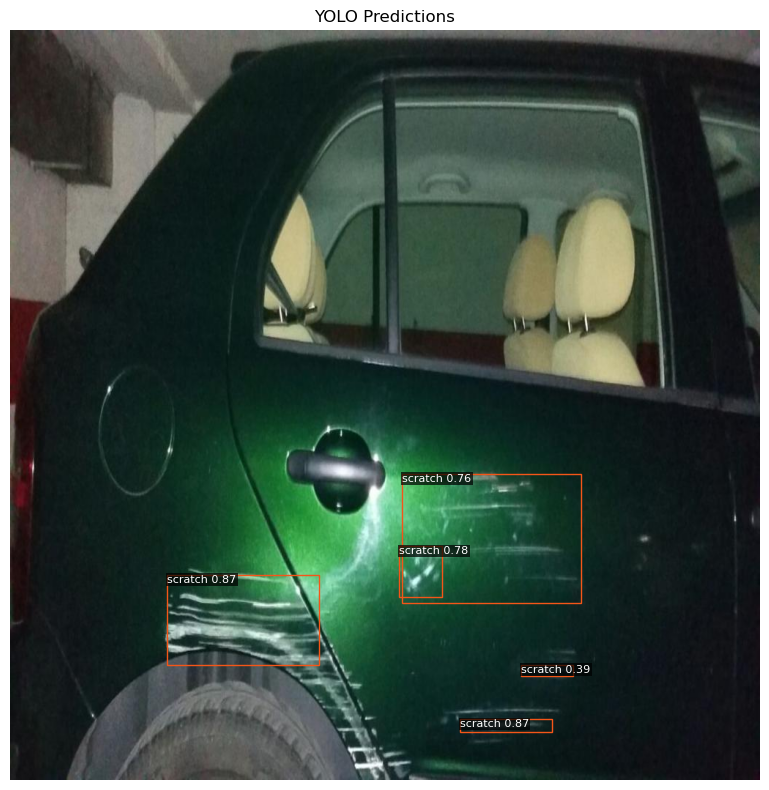

In [ ]:
from detection.detector import Detector

model_damage = Detector('path/to/model')
file_path = 'path/to/file'

infer = Inference(model_damage, file_path)
infer.run(conf=0.3)